In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import os

#  Load  and prepare HW and NO_HW df

##  Load HW data

In [ ]:
# Load the parquet data from /Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/parquet
#data_dir = '/Users/yguo/DataSpellProjects/hw/data/parquet'
data_dir = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/parquet'
file_name_hw = 'HW_1985_1994.parquet'
#join data_dir and file_name
hw_path = os.path.join(data_dir, file_name_hw)
df_hw = pd.read_parquet(hw_path)
print(df_hw.info())
df_hw

##  Add hour, month and year to the df_hw


In [ ]:
# Ensure 'time' is of datetime type
df_hw.index = df_hw.index.set_levels([df_hw.index.levels[0], df_hw.index.levels[1], pd.to_datetime(df_hw.index.levels[2])])

# Extract hour, month and year from 'time'
df_hw['hour'] = df_hw.index.get_level_values('time').hour
df_hw['month'] = df_hw.index.get_level_values('time').month
df_hw['year'] = df_hw.index.get_level_values('time').year
df_hw

In [ ]:
# # Group by 'lat', 'lon', 'year', 'month', and 'hour', then calculate the mean of 'UHI' and 'UBWI'
# df_hw_avg = df_hw.groupby(['lat', 'lon', 'year', 'month', 'hour']).mean()
# df_hw_avg

##  Load NO_HW data

In [ ]:

file_name_no_hw = 'NO_HW_1985_1994.parquet'
#join data_dir and file_name
no_hw_path = os.path.join(data_dir, file_name_no_hw)
df_no_hw = pd.read_parquet(no_hw_path)
print(df_no_hw.info())
df_no_hw

In [ ]:
#todo: add UHI and NO_HW UHI to make sure they are the same as the oringal netcdf data


##  Validate there is not overlap between the HW and NO_HW data

In [ ]:
#the key for both df_hw and df_no_hw are lat, lon and time. please show python code that they don't overlap on those keys
# Convert the MultiIndex of both DataFrames to sets
# keys_hw = set(df_hw.index)
# keys_no_hw = set(df_no_hw.index)
# 
# # Check if the intersection of these sets is empty
# overlap = keys_hw & keys_no_hw
# 
# # If the intersection is empty, print that there is no overlap. Otherwise, print the overlapping keys.
# if not overlap:
#     print("There is no overlap between the keys of df_hw and df_no_hw.")
# else:
#     print("The following keys overlap between df_hw and df_no_hw:")
#     print(overlap)

In [ ]:

# group df_no_hw by lat, lon, year and hour of the day avaerage UHI and UBWI
df_no_hw.index = df_no_hw.index.set_levels(
    [df_no_hw.index.levels[0], df_no_hw.index.levels[1], pd.to_datetime(df_no_hw.index.levels[2])])
df_no_hw['hour'] = df_no_hw.index.get_level_values('time').hour
df_no_hw['year'] = df_no_hw.index.get_level_values('time').year
df_no_hw_avg = df_no_hw.groupby(['lat', 'lon', 'year', 'hour']).mean()
df_no_hw_avg

#  2: Calculate the difference between UHI in df_hw and df_no_hw

##  UHI HW - NO_HW ( HW hour data - NO_HW yearl average data for the hour) 
the df_no_hw_avg is the average value for a given hour of the day throughout the year.
In the 2018 Zhao paper they seem to just do average the whole 30 years. 
I want to substract the average UHI on the given hour for a given year from the hourly UHI data I have in df_hw, matching the year and hour between the two dataframes.


##  Step 2.1: Reset the index of df_hw and df_no_hw_avg (be careful on the increased memory usage)

In [ ]:
df_hw.info()
df_hw_reset = df_hw.reset_index()
df_hw_reset.info()
df_no_hw_avg.info()
df_no_hw_avg_reset = df_no_hw_avg.reset_index()
df_no_hw_avg_reset.info()



##   Step 2.2: Merge df_hw with df_no_hw_avg_reset

In [ ]:

merged_df = pd.merge(df_hw_reset, df_no_hw_avg_reset[['lat', 'lon', 'year', 'hour', 'UHI', 'UBWI']],
                     on=['lat', 'lon', 'year', 'hour'],
                     suffixes=('', '_avg'))

In [ ]:
merged_df.info()
merged_df.head()


##  Step 2.3: Subtract the average UHI from the hourly UHI and store in a new column

In [ ]:

merged_df['UHI_diff'] = merged_df['UHI'] - merged_df['UHI_avg']
merged_df['UBWI_diff'] = merged_df['UBWI'] - merged_df['UBWI_avg']
# Now, merged_df contains your original data along with the subtracted UHI values in 'UHI_diff'
merged_df  # To check the first few rows of the merged DataFrame

In [ ]:
merged_df[['UHI_diff', 'UBWI_diff']].describe()

In [ ]:
merged_df.info()

## (Optional) Step 2.4: Validate the results by checking the UHI values for a specific location and time

In [ ]:

row_index = 198
print(merged_df.iloc[row_index].UHI_avg)
a_row = merged_df.iloc[row_index]
df_no_hw_avg_reset.loc[(df_no_hw_avg_reset['lat'] == a_row.lat) & (df_no_hw_avg_reset['lon'] == a_row.lon) & (
                df_no_hw_avg_reset['year'] == a_row.year) & (
                df_no_hw_avg_reset['hour'] == a_row.hour)].UHI


#  3: Averaged data for each local hour 

##  Step 3.1: Adjust to local hour

In [ ]:
import pandas as pd
import numpy as np

def convert_time_to_local_and_add_hour(df):
    """
    Converts the UTC timestamp in the DataFrame to local time based on longitude and adds a column for the local hour.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns for latitude ('lat'), longitude ('lon'), and UTC timestamp ('time')
    
    Returns:
    pd.DataFrame: DataFrame with additional columns ('local_time' and 'local_hour') for the timestamp adjusted to local time and the hour extracted from the local time
    """
    # Function to calculate timezone offset from longitude
    def calculate_timezone_offset(longitude):
        return np.floor(longitude / 15.0).astype(int)  # Approximate, not accounting for DST or specific timezone rules

    # Calculate timezone offsets for each row based on longitude
    offsets = calculate_timezone_offset(df['lon'].values)

    # Adjust timestamps by the offsets
    df['local_time'] = df['time'] + pd.to_timedelta(offsets, unit='h')

    # Extract the hour from the 'local_time' and create a new column
    df['local_hour'] = df['local_time'].dt.hour

    return df

# # Assuming 'df' is your original DataFrame
# # Make sure 'time' column is in datetime format
# df['time'] = pd.to_datetime(df['time'])

# # Convert UTC times to local times based on longitude and add local hour
# df = convert_time_to_local_and_add_hour(df)


In [ ]:
merged_df = convert_time_to_local_and_add_hour(merged_df)
merged_df


In [ ]:
merged_df.info()

##  Step 3.2 compute average based on local hour

In [ ]:
os.environ["PROJ_LIB"] = "/home/jguo/anaconda3/envs/I2000/share/proj"
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Group by 'lat', 'lon', and 'local_hour', then calculate the mean for 'UHI_diff'
# Ensure grouped data is sorted by 'lat' and 'lon' before pivoting
var_diff_by_localhour = merged_df.groupby(['lat', 'lon', 'local_hour'])['UHI_diff'].mean().reset_index().sort_values(by=['lat', 'lon', 'local_hour'])

var_diff_by_localhour


In [ ]:
var_diff_by_localhour.info()

# 4: Plot and Explore

## See the hourly pattern of UHI_diff

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd



# Function to normalize longitude values to the range [-180, 180]
def normalize_longitude(lon):
    return ((lon + 180) % 360) - 180

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd

# Assuming 'var_diff_by_localhour' is your DataFrame

# Function to normalize longitude values to the range [-180, 180]
def normalize_longitude(lon):
    return ((lon + 180) % 360) - 180

# Normalize the longitude values in your DataFrame
var_diff_by_localhour['lon'] = var_diff_by_localhour['lon'].apply(normalize_longitude)

In [ ]:



# Define the map drawing function for subplots
def draw_map_subplot(m, ax):
    m.drawcoastlines(linewidth=0.5, ax=ax)
    m.drawcountries(linewidth=0.5, ax=ax)
    m.fillcontinents(color='coral', lake_color='aqua', alpha=0.3, ax=ax)
    m.drawmapboundary(fill_color='aqua', ax=ax)
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], fontsize=10, ax=ax)
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=10, ax=ax)

# Find global min and max of UHI_diff
global_min = var_diff_by_localhour['UHI_diff'].min()
global_max = var_diff_by_localhour['UHI_diff'].max()

# Calculate the number of rows needed for the subplots
n_hours = len(var_diff_by_localhour['local_hour'].unique())
n_rows = (n_hours + 2) // 3  # Adding 2 to ensure rounding up if there's a remainder

# Create a figure to hold all subplots
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 6), constrained_layout=True)

# Iterate through each local_hour to create subplots
for i, hour in enumerate(var_diff_by_localhour['local_hour'].unique()):
    row, col = divmod(i, 3)
    ax = axs[row, col] if n_rows > 1 else axs[col]  # Adjust for the case of a single row

    # Setup the Basemap
    m = Basemap(projection='cyl', resolution='l', lat_0=0, lon_0=0, ax=ax)

    draw_map_subplot(m, ax)

    # Filter data for the current hour
    df_hour = var_diff_by_localhour[var_diff_by_localhour['local_hour'] == hour]

    # Scatter UHI_diff data
    x, y = m(df_hour['lon'].values, df_hour['lat'].values)
    # Set vmin and vmax to the global min/max values
    sc = m.scatter(x, y, c=df_hour['UHI_diff'], vmin=global_min, vmax=global_max, cmap='hot', marker='o', edgecolor='none', alpha=0.75, ax=ax)

    ax.set_title(f'UHI Difference Map at Local Hour {hour}')

    # Add color bar to each subplot
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label='UHI_diff')

plt.show()



## UHI_diff by local hour

In [ ]:
# Grouping by 'local_hour' and calculating the mean of 'UHI_diff'
uhi_hourly = var_diff_by_localhour.groupby('local_hour')['UHI_diff'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(uhi_hourly['local_hour'], uhi_hourly['UHI_diff'], marker='o')
plt.title('Mean UHI Difference by Local Hour')
plt.xlabel('Local Hour')
plt.ylabel('Mean UHI Difference')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

I have some understanding about UHI:
1. Diurnal Cycle of Solar Radiation: During the daytime, solar radiation is the primary source of heat for both urban and rural areas. However, urban surfaces, with their lower albedo and higher heat capacity, tend to absorb and store more solar radiation than rural surfaces. This leads to a smaller UHI effect during the day. At night, the absence of solar radiation allows the stored heat in urban areas to be gradually released, resulting in a stronger UHI effect at night.
2. Boundary Layer Dynamics: The atmospheric boundary layer, the layer of air closest to the Earth's surface, plays a crucial role in heat dissipation. During the day, the boundary layer is typically deeper and more turbulent, promoting greater mixing and heat exchange between the surface and the atmosphere. This can help to mitigate the UHI effect. At night, the boundary layer becomes shallower and more stable, trapping heat near the surface and intensifying the UHI effect.

I need to better understand why the synergy is also showing a diurnal cycle.

##  Koppen Geiger Climate Analysis

In [65]:

import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the NetCDF file
ds_koppen_map = xr.open_dataset('/home/jguo/other_projects/1991_2020/koppen_geiger_0p5.nc')
#ds_koppen_map.kg_class.min()

# Load the Koppen Geiger Legend Excel file
kg_legend = pd.read_excel('/home/jguo/research/hw_global/Data/KoppenGeigerLegend.xlsx', engine='openpyxl')
kg_legend

,ID,KGShort,KGClass,Color
0,1,Af,"Tropical, rainforest",[0 0 255]
1,2,Am,"Tropical, monsoon",[0 120 255]
2,3,Aw,"Tropical, savannah",[70 170 250]
3,4,BWh,"Arid, desert, hot",[255 0 0]
4,5,BWk,"Arid, desert, cold",[255 150 150]
5,6,BSh,"Arid, steppe, hot",[245 165 0]
6,7,BSk,"Arid, steppe, cold",[255 220 100]
7,8,Csa,"Temperate, dry summer, hot summer",[255 255 0]
8,9,Csb,"Temperate, dry summer, warm summer",[200 200 0]
9,10,Csc,"Temperate, dry summer, cold summer",[150 150 0]


In [66]:

# Convert latitudes and longitudes from the NetCDF dataset to numpy arrays
latitudes = ds_koppen_map['lat'].values
longitudes = ds_koppen_map['lon'].values

# Flatten the latitudes, longitudes, and kg_class for easier manipulation
lat_flat = np.repeat(latitudes, len(longitudes))
lon_flat = np.tile(longitudes, len(latitudes))
kg_class_flat = ds_koppen_map['kg_class'].values.flatten()

# Filter out the zero kg_class values
non_zero_indices = kg_class_flat > 0
lat_flat_non_zero = lat_flat[non_zero_indices]
lon_flat_non_zero = lon_flat[non_zero_indices]
kg_class_flat_non_zero = kg_class_flat[non_zero_indices]

# Function to find the nearest non-zero kg_class for given lat and lon
def find_nearest_non_zero_kg_class(lat, lon):
    distances = np.sqrt((lat_flat_non_zero - lat)**2 + (lon_flat_non_zero - lon)**2)
    nearest_index = np.argmin(distances)
    return kg_class_flat_non_zero[nearest_index]

# Vectorize the function to apply it efficiently to arrays
vec_find_nearest_non_zero_kg_class = np.vectorize(find_nearest_non_zero_kg_class)

# Apply the vectorized function to each lat and lon in var_diff_by_localhour
var_diff_by_localhour['KG_ID'] = vec_find_nearest_non_zero_kg_class(var_diff_by_localhour['lat'].values, var_diff_by_localhour['lon'].values)
var_diff_by_localhour

,lat,lon,local_hour,UHI_diff,KG_ID
0,-45.706806,-67.50,0,0.309058,5.0
1,-45.706806,-67.50,1,0.279969,5.0
2,-45.706806,-67.50,2,0.267653,5.0
3,-45.706806,-67.50,3,0.260591,5.0
4,-45.706806,-67.50,4,0.326137,5.0
...,...,...,...,...,...
81355,62.670158,113.75,19,0.351530,27.0
81356,62.670158,113.75,20,0.619992,27.0
81357,62.670158,113.75,21,0.852597,27.0
81358,62.670158,113.75,22,1.000981,27.0


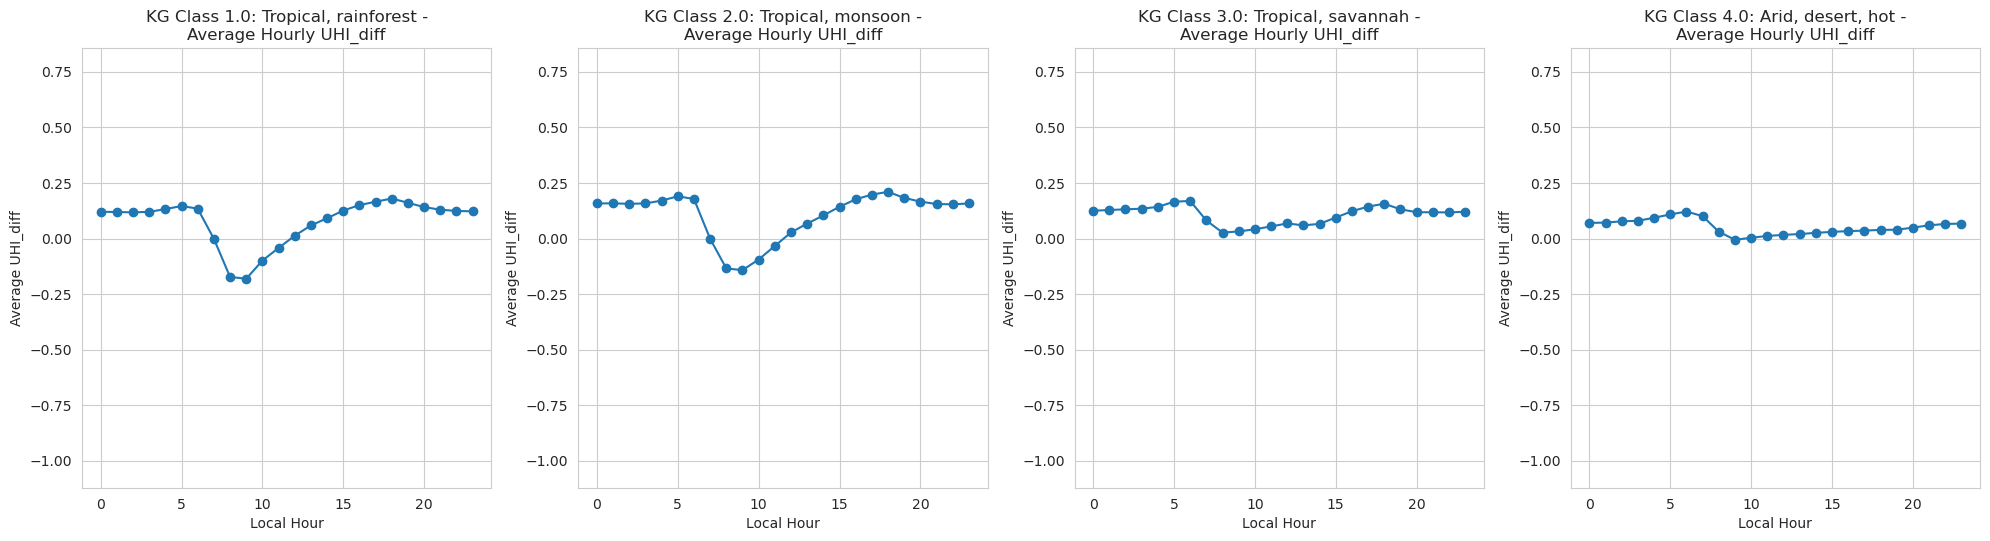

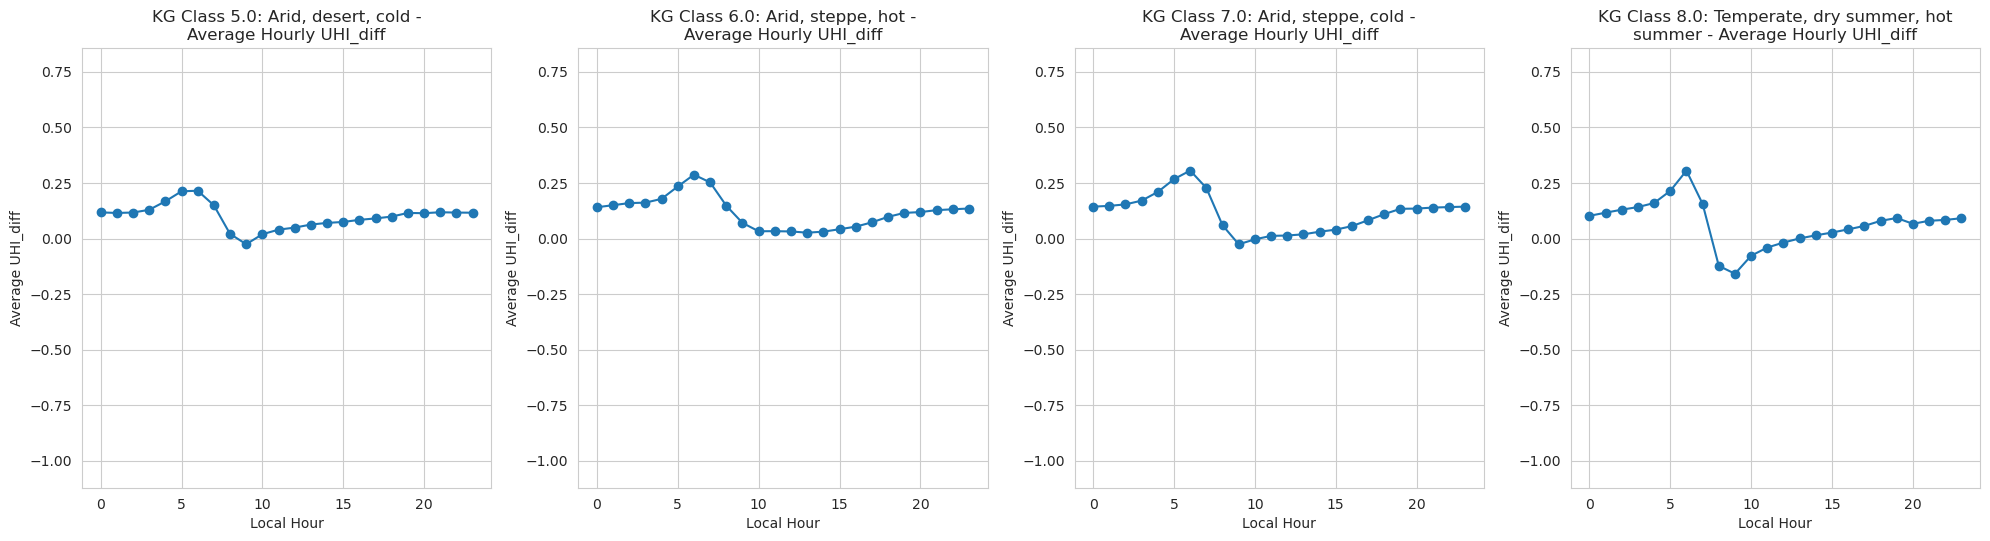

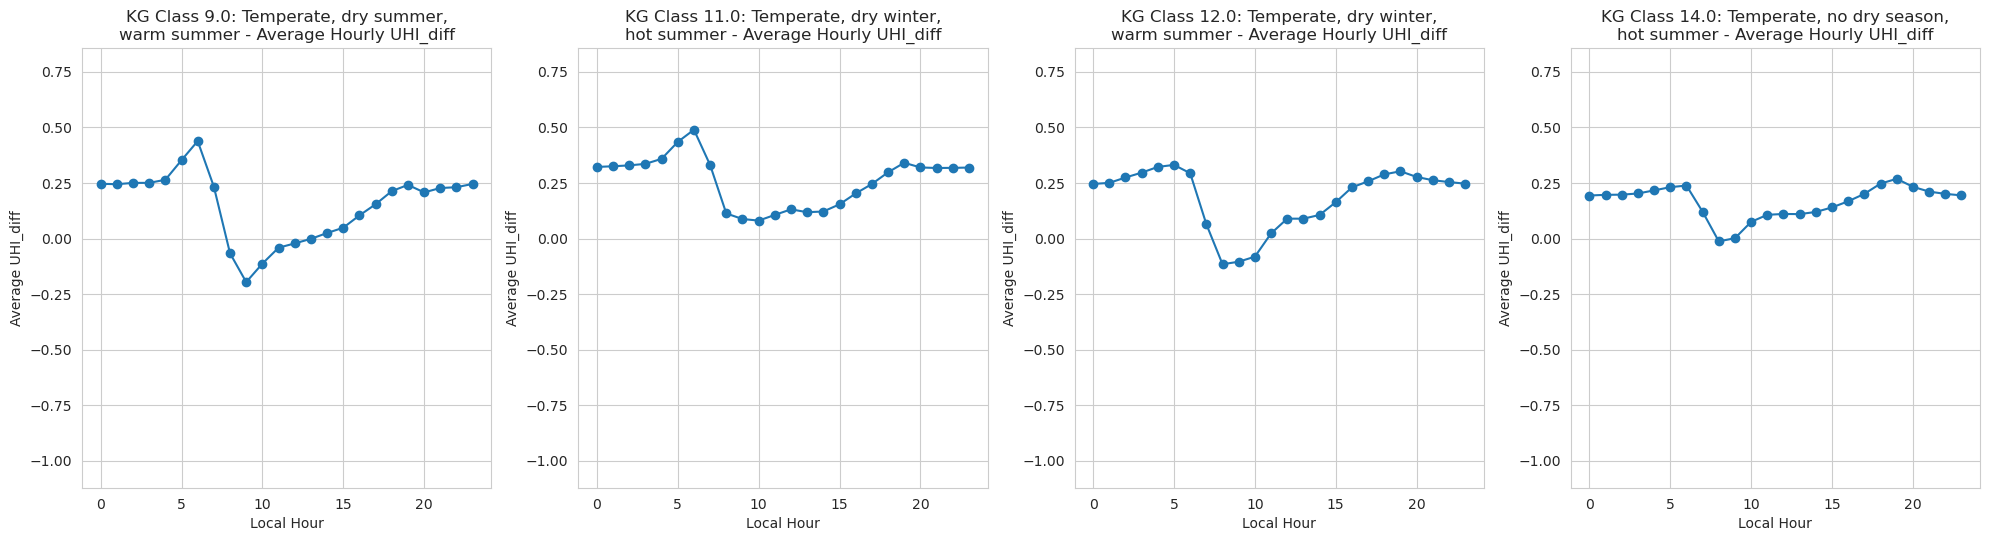

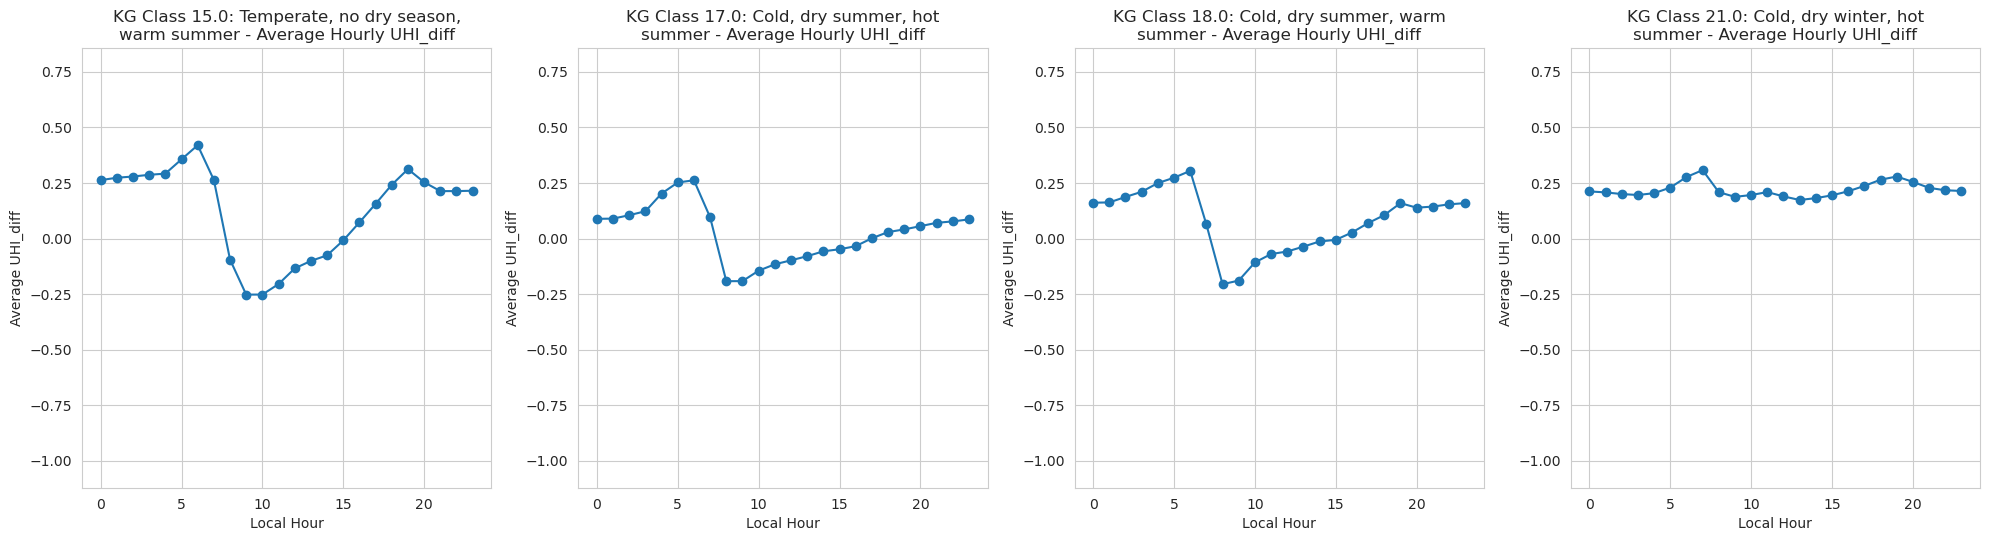

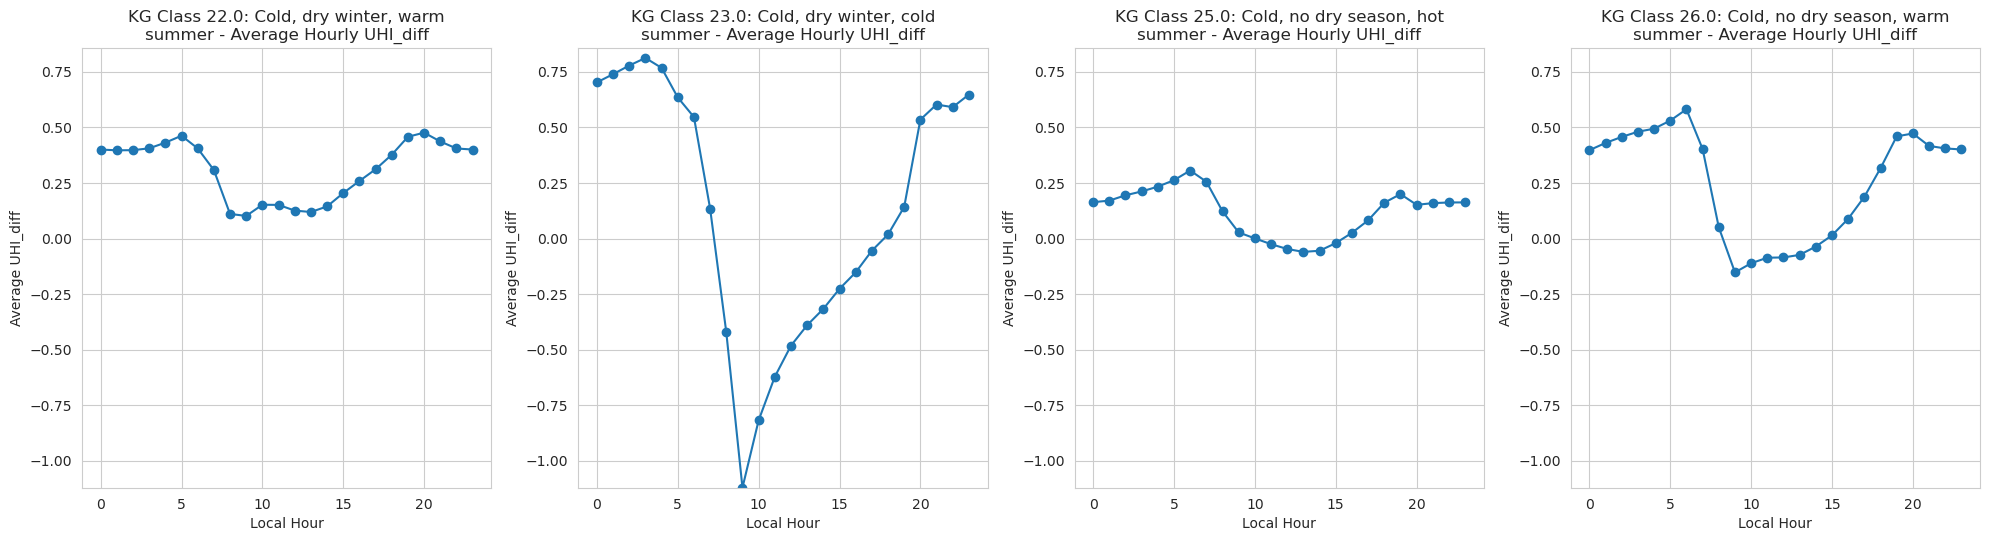

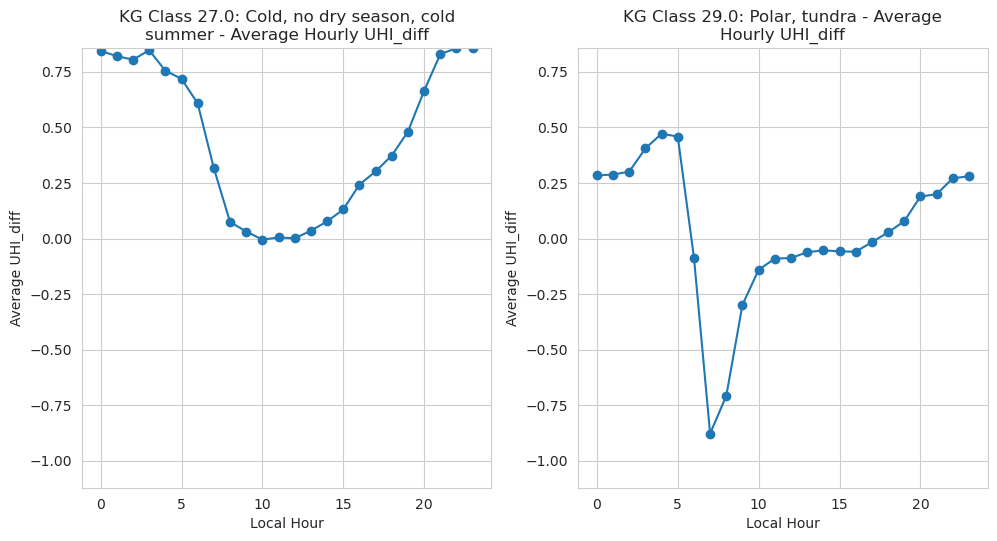

In [67]:

# Calculate average UHI_diff by local_hour for each KG class
avg_uhi_by_hour_and_kg = var_diff_by_localhour.groupby(['KG_ID', 'local_hour'])['UHI_diff'].mean().reset_index()
# Map KG classes to their descriptions
kg_map = dict(zip(kg_legend['ID'], kg_legend['KGClass']))
# Plotting
import textwrap

# Define the number of graphs you want in each row
graphs_per_row = 4  # You can change this number to your preference

# Find the global minimum and maximum UHI_diff values for consistent y-axis limits
global_min_uhi = avg_uhi_by_hour_and_kg['UHI_diff'].min()
global_max_uhi = avg_uhi_by_hour_and_kg['UHI_diff'].max()

# Unique KG IDs
unique_kg_ids = avg_uhi_by_hour_and_kg['KG_ID'].unique()

# Number of KG IDs
n_kg_ids = len(unique_kg_ids)

# Calculate the number of rows needed
n_rows = (n_kg_ids + graphs_per_row - 1) // graphs_per_row  # Ensures rounding up

# Loop through each KG ID
for i, kg_id in enumerate(unique_kg_ids):
    # Create a new figure at the start and after every 'graphs_per_row' plots
    if i % graphs_per_row == 0:
        plt.figure(figsize=(5 * graphs_per_row, 5 * n_rows))  # Adjust figure size as needed
    # Select the subplot position
    plt.subplot(n_rows, graphs_per_row, i % graphs_per_row + 1)

    # Extract the subset of data for the current KG ID
    subset = avg_uhi_by_hour_and_kg[avg_uhi_by_hour_and_kg['KG_ID'] == kg_id]

    # Plot the data
    plt.plot(subset['local_hour'], subset['UHI_diff'], marker='o')

    # Wrap the title text
    title_text = f'KG Class {kg_id}: {kg_map.get(kg_id, "Unknown")} - Average Hourly UHI_diff'
    wrapped_title = textwrap.fill(title_text, width=40)  # Adjust 'width' as needed

    plt.title(wrapped_title)
    plt.xlabel('Local Hour')
    plt.ylabel('Average UHI_diff')
    plt.grid(True)

    # Set the same y-axis limits for all plots
    plt.ylim(global_min_uhi, global_max_uhi)

    # Show the figure after every 'graphs_per_row' plots or on the last plot
    if (i % graphs_per_row == graphs_per_row - 1) or (i == n_kg_ids - 1):
        plt.tight_layout()
        plt.show()






#   Miscalanous items

## Count number of HW days

In [ ]:
df_count = df_hw.groupby(['lat', 'lon']).size()
df_count

In [ ]:
df_count_sorted = df_count.sort_values(ascending=False).reset_index()
df_count_sorted

In [ ]:

df_count_sorted['lon'] = df_count_sorted['lon'].apply(normalize_longitude)
df_count_sorted = df_count_sorted.set_index(['lat', 'lon']) 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Create a figure with a specific size
plt.figure(figsize=(12, 6))
df_count_sorted /= 365 # number of HW days per year

# Create a Basemap instance for a simple cylindrical projection, with coastlines and country boundaries
m = Basemap(projection='cyl', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)

# Convert latitudes and longitudes to map projection coordinates
x, y = m(df_count_sorted.index.get_level_values('lon').values, df_count_sorted.index.get_level_values('lat').values)

# Scatter plot: plotting the total HW values for each grid cell on the map
m.scatter(x, y, c=df_count_sorted.values, s=10, cmap='Reds', alpha=0.75, latlon=False)

# Add a color bar to indicate the scale of HW values
plt.colorbar(label='Total HW / Year')

# Title for the map
plt.title('Global Map Showing Total HW on Each Grid Cell')

plt.show()

## group by north south hemisphere

In [ ]:
var_diff_by_localhour.groupby(lambda x: (var_diff_by_localhour.loc[x, 'lat'] > 0, var_diff_by_localhour.loc[x, 'local_hour']))['UHI_diff'].mean()

## Load koppen map tiff file

In [ ]:
import xarray as xr
import rioxarray

# Open the GeoTIFF file as an xarray DataSet
#file_path = '/home/jguo/other_projects/koppen_geiger_tif/1991_2020/koppen_geiger_0p1.tif'
pic_path = '/home/jguo/other_projects/koppen_geiger_tif/1991_2020/koppen_geiger_1p0.tif'
# xds = rioxarray.open_rasterio('/home/jguo/other_projects/koppen_geiger_tif/1991_2020/koppen_geiger_0p1.tif')
ds_koppen = xr.open_dataset(pic_path, engine="rasterio")
# Now `xds` is an xarray DataSet with the raster data and spatial coordinates
ds_koppen




In [ ]:
import rasterio
src = rasterio.open(pic_path)
src.colormap(1)

In [ ]:
ds_koppen.band_data.plot()

In [ ]:
ds_koppen.to_dataframe()

##  Koppen Geiger Climate Analysis

In [ ]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the NetCDF file
ds_koppen_map = xr.open_dataset('/home/jguo/other_projects/1991_2020/koppen_geiger_0p5.nc')
#ds_koppen_map.kg_class.min()

In [ ]:

# Load the Koppen Geiger Legend Excel file
kg_legend = pd.read_excel('/home/jguo/research/hw_global/Data/KoppenGeigerLegend.xlsx', engine='openpyxl')
kg_legend

In [ ]:

# Convert latitudes and longitudes from the NetCDF dataset to numpy arrays
latitudes = ds_koppen_map['lat'].values
longitudes = ds_koppen_map['lon'].values

# Flatten the latitudes, longitudes, and kg_class for easier manipulation
lat_flat = np.repeat(latitudes, len(longitudes))
lon_flat = np.tile(longitudes, len(latitudes))
kg_class_flat = ds_koppen_map['kg_class'].values.flatten()

# Filter out the zero kg_class values
non_zero_indices = kg_class_flat > 0
lat_flat_non_zero = lat_flat[non_zero_indices]
lon_flat_non_zero = lon_flat[non_zero_indices]
kg_class_flat_non_zero = kg_class_flat[non_zero_indices]

# Function to find the nearest non-zero kg_class for given lat and lon
def find_nearest_non_zero_kg_class(lat, lon):
    distances = np.sqrt((lat_flat_non_zero - lat)**2 + (lon_flat_non_zero - lon)**2)
    nearest_index = np.argmin(distances)
    return kg_class_flat_non_zero[nearest_index]

# Vectorize the function to apply it efficiently to arrays
vec_find_nearest_non_zero_kg_class = np.vectorize(find_nearest_non_zero_kg_class)

# Apply the vectorized function to each lat and lon in var_diff_by_localhour
var_diff_by_localhour['KG_ID'] = vec_find_nearest_non_zero_kg_class(var_diff_by_localhour['lat'].values, var_diff_by_localhour['lon'].values)

In [ ]:
var_diff_by_localhour

In [ ]:

# Calculate average UHI_diff by local_hour for each KG class
avg_uhi_by_hour_and_kg = var_diff_by_localhour.groupby(['KG_ID', 'local_hour'])['UHI_diff'].mean().reset_index()

In [ ]:
# Map KG classes to their descriptions
kg_map = dict(zip(kg_legend['ID'], kg_legend['KGClass']))
# Plotting
import textwrap

# Define the number of graphs you want in each row
graphs_per_row = 4  # You can change this number to your preference

# Find the global minimum and maximum UHI_diff values for consistent y-axis limits
global_min_uhi = avg_uhi_by_hour_and_kg['UHI_diff'].min()
global_max_uhi = avg_uhi_by_hour_and_kg['UHI_diff'].max()

# Unique KG IDs
unique_kg_ids = avg_uhi_by_hour_and_kg['KG_ID'].unique()

# Number of KG IDs
n_kg_ids = len(unique_kg_ids)

# Calculate the number of rows needed
n_rows = (n_kg_ids + graphs_per_row - 1) // graphs_per_row  # Ensures rounding up

# Loop through each KG ID
for i, kg_id in enumerate(unique_kg_ids):
    # Create a new figure at the start and after every 'graphs_per_row' plots
    if i % graphs_per_row == 0:
        plt.figure(figsize=(5 * graphs_per_row, 5 * n_rows))  # Adjust figure size as needed

    # Select the subplot position
    plt.subplot(n_rows, graphs_per_row, i % graphs_per_row + 1)

    # Extract the subset of data for the current KG ID
    subset = avg_uhi_by_hour_and_kg[avg_uhi_by_hour_and_kg['KG_ID'] == kg_id]

    # Plot the data
    plt.plot(subset['local_hour'], subset['UHI_diff'], marker='o')

    # Wrap the title text
    title_text = f'KG Class {kg_id}: {kg_map.get(kg_id, "Unknown")} - Average Hourly UHI_diff'
    wrapped_title = textwrap.fill(title_text, width=40)  # Adjust 'width' as needed

    plt.title(wrapped_title)
    plt.xlabel('Local Hour')
    plt.ylabel('Average UHI_diff')
    plt.grid(True)

    # Set the same y-axis limits for all plots
    plt.ylim(global_min_uhi, global_max_uhi)

    # Show the figure after every 'graphs_per_row' plots or on the last plot
    if (i % graphs_per_row == graphs_per_row - 1) or (i == n_kg_ids - 1):
        plt.tight_layout()
        plt.show()




